## ConvLSTM NDVI forecasting using NDVI and LST
- 3 input (3 NDVI) with 3 output (3 NDVI) (distinct timestep)
- NDVI:
  - source: MODIS/061/MOD13A2
  - interval
  - resolution 1km
  - image: 84x65 pixel

In [1]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [2]:
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 34.4 MB/s eta 0:00:00


In [3]:
import rasterio
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
ndvi_path = './NDVI-data-65x84'
ndvi_tif_files = glob.glob(ndvi_path+"/*.tif")

ndvi_tif_files.sort()
len(ndvi_tif_files)

526

In [5]:
ndvi_data_dates = [file_name.split('/')[-1].split('.')[0] for file_name in ndvi_tif_files]

print(ndvi_data_dates[-5:])
print('\n', len(ndvi_data_dates))

## date indexing

periods = [period for period in range(0, len(ndvi_data_dates), 6)]
ndvi_dataset_dates = []
for i in range(len(ndvi_data_dates)-5):
  period_date = []
  for date in ndvi_data_dates[i:i+6]:
    period_date.append(date)
  period_date_arr = np.array(period_date)
  ndvi_dataset_dates.append(period_date_arr)

['2022_10_16', '2022_11_01', '2022_11_17', '2022_12_03', '2022_12_19']

 526


In [15]:
ndvi_dataset_dates_arr = np.array(ndvi_dataset_dates[:518])

In [6]:
crs_list = []
transform_list = []

periods = [period for period in range(0, len(ndvi_tif_files), 6)]
ndvi_dataset = []
for i in range(len(ndvi_tif_files)-5):
  period_data = []
  for file_ in ndvi_tif_files[i:i+6]:
    ndvi_data = rasterio.open(file_)
    ndvi_data_arr = ndvi_data.read(1)
    ndvi_data_crs = ndvi_data.crs  # Get the coordinate reference system (CRS)
    crs_list.append(ndvi_data_crs)
    ndvi_data_transform = ndvi_data.transform # Get the transformation matrix
    transform_list.append(ndvi_data_transform)
    period_data.append(ndvi_data_arr)
  period_data_arr = np.array(period_data)
  ndvi_dataset.append(period_data_arr)

In [9]:
ndvi_dataset_arr = np.array(ndvi_dataset[:518])
ndvi_dataset_arr.shape

(518, 6, 84, 65)

In [10]:
samples = ndvi_dataset_arr.shape[0]
time_steps = ndvi_dataset_arr.shape[1]
height, width = ndvi_dataset_arr.shape[2], ndvi_dataset_arr.shape[3]
channels = 1

ndvi_data_raw = ndvi_dataset_arr.reshape(samples, time_steps, height, width, channels)

In [11]:
# Normalize NDVI values to range [0, 1]
ndvi_scaler = MinMaxScaler()
normalized_ndvi_data = ndvi_scaler.fit_transform(ndvi_data_raw.reshape(-1, 1))
ndvi_data = normalized_ndvi_data.reshape(518, 6, 84, 65, 1)

In [12]:
indexes = np.arange(ndvi_data.shape[0])

train_index = indexes[: int(0.8 * ndvi_data.shape[0])]
val_index = indexes[int(0.8 * ndvi_data.shape[0]) :]

In [13]:
ndvi_train_dataset = ndvi_data[train_index, :, :, :, :]
ndvi_val_dataset = ndvi_data[val_index, :, :, :, :]

In [14]:
ndvi_train_dataset.shape

(414, 6, 84, 65, 1)

In [23]:
ndvi_dataset_dates_arr[413]

array(['2018_02_02', '2018_02_18', '2018_03_06', '2018_03_22',
       '2018_04_07', '2018_04_23'], dtype='<U10')

In [24]:
ndvi_val_dataset_date[0]

array(['2018_02_18', '2018_03_06', '2018_03_22', '2018_04_07',
       '2018_04_23', '2018_05_09'], dtype='<U10')

In [16]:
ndvi_train_dataset_date = ndvi_dataset_dates_arr[train_index, :]
ndvi_val_dataset_date = ndvi_dataset_dates_arr[val_index, :]

In [17]:
def create_shifted_frames(data):
    x = data[:, 0:data.shape[1]-3, :, :, :]
    y = data[:, 3:data.shape[1], :, :, :]
    return x, y


# Apply the processing function to the datasets.
x_train_ndvi, y_train_ndvi = create_shifted_frames(ndvi_train_dataset)
x_val_ndvi, y_val_ndvi = create_shifted_frames(ndvi_val_dataset)

In [18]:
print("Training Dataset Shapes: " + str(x_train_ndvi.shape) + ", " + str(y_train_ndvi.shape))
print("Validation Dataset Shapes: " + str(x_val_ndvi.shape) + ", " + str(y_val_ndvi.shape))

Training Dataset Shapes: (414, 3, 84, 65, 1), (414, 3, 84, 65, 1)
Validation Dataset Shapes: (104, 3, 84, 65, 1), (104, 3, 84, 65, 1)


In [19]:
input = layers.Input(shape=(3, 84, 65, 1))
input

<KerasTensor: shape=(None, 3, 84, 65, 1) dtype=float32 (created by layer 'input_1')>

In [20]:
# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(7, 7),
    padding="same",
    return_sequences=True,
    activation="relu",
)(input)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)

x = layers.Conv2D(
    filters=1, kernel_size=(3, 3), activation="linear", padding="same"
)(x)

In [21]:
# Next, we will build the complete model and compile it.
model = keras.models.Model(input, x)
model.compile(
    loss=tf.keras.losses.mean_squared_error, optimizer=keras.optimizers.Adam(),
)

In [22]:
## Model Training

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

## model checkpoint
model_ckpt = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/summer-internship/model-training/ndvi_50epoch_distinct_3to3.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 2

In [25]:
# Fit the model to the training data.
model.fit(
    x_train_ndvi,
    y_train_ndvi,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val_ndvi, y_val_ndvi),
    callbacks=[early_stopping, reduce_lr, model_ckpt],
)

Epoch 1/50
207/207 [==============================] - ETA: 0s - loss: 0.0312
Epoch 1: val_loss improved from inf to 0.10828, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi_50epoch_distinct_3to3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


207/207 [==============================] - 54s 172ms/step - loss: 0.0312 - val_loss: 0.1083 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - ETA: 0s - loss: 0.0227
Epoch 2: val_loss did not improve from 0.10828
207/207 [==============================] - 33s 157ms/step - loss: 0.0227 - val_loss: 0.1570 - lr: 0.0010
Epoch 3/50
207/207 [==============================] - ETA: 0s - loss: 0.0212
Epoch 3: val_loss improved from 0.10828 to 0.05915, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi_50epoch_distinct_3to3.h5
207/207 [==============================] - 34s 165ms/step - loss: 0.0212 - val_loss: 0.0591 - lr: 0.0010
Epoch 4/50
207/207 [==============================] - ETA: 0s - loss: 0.0204
Epoch 4: val_loss improved from 0.05915 to 0.02585, saving model to /content/drive/MyDrive/summer-internship/model-training/ndvi_50epoch_distinct_3to3.h5
207/207 [==============================] - 33s 161ms/step - loss: 0.0204 - val_loss: 0.0259 - lr: 0

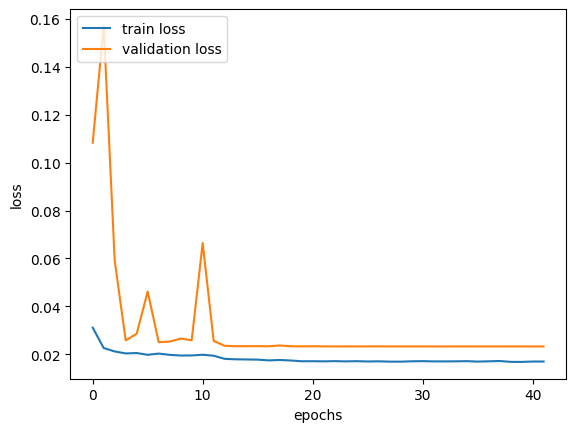

In [26]:
plt.plot(model.history.history['loss'], label='train loss')
plt.plot(model.history.history['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.show()

In [27]:
def r2_score_and_mse(actual_images, predicted_images):
  actual_images = tf.convert_to_tensor(actual_images, dtype=tf.float32)
  predicted_images = tf.convert_to_tensor(predicted_images, dtype=tf.float32)

  mse = tf.keras.losses.mean_squared_error(actual_images, predicted_images)
  mse_mean = tf.reduce_mean(mse)

  # Calculate the sum of squares of the residuals (SSR)
  SSR = tf.reduce_sum(tf.square(actual_images - predicted_images))

  # Calculate the total sum of squares (SST)
  mean_actual = tf.reduce_mean(actual_images)
  SST = tf.reduce_sum(tf.square(actual_images - mean_actual))

  # Calculate R2-score
  r2_score = 1 - (SSR / SST)

  return r2_score.numpy(), mse_mean

In [ ]:
%%time
y_prediction_ = load_model.predict(np.expand_dims(x_combined_val[-1], axis=0))
y_prediction_.shape

- Model size: 22.6 MB
- Train loss:  0.0171
- Val loss: 0.02330

In [ ]:
Certainly, if you want to provide both NDVI and CHIRPS data as input to a ConvLSTM model, you can do so by stacking the channels of these two types of data and using them as input. Here's how you can modify the code to achieve this:

```python
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D

# Sample data dimensions (replace with actual dimensions)
num_samples = 100
time_steps = 5
height = 64
width = 64
num_channels_ndvi = 1  # NDVI
num_channels_chirps = 1  # CHIRPS

# Generate sample data (replace with your actual data)
X_ndvi = np.random.rand(num_samples, time_steps, height, width, num_channels_ndvi)
X_chirps = np.random.rand(num_samples, time_steps, height, width, num_channels_chirps)
y_ndvi = np.random.rand(num_samples, height, width, num_channels_ndvi)

# Stack CHIRPS and NDVI channels along the last dimension
input_data = Input(shape=(time_steps, height, width, num_channels_ndvi + num_channels_chirps))

# Define a ConvLSTM layer that operates on the stacked input
convlstm = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False)(input_data)

# Additional convolutional layers to predict NDVI
conv_out = Conv2D(filters=num_channels_ndvi, kernel_size=(3, 3), activation='linear', padding='same')(convlstm)

# Create the model
model = Model(inputs=input_data, outputs=conv_out)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model.summary()

# Train the model
model.fit(np.concatenate((X_ndvi, X_chirps), axis=-1), y_ndvi, batch_size=32, epochs=10, validation_split=0.2)

# Make predictions
predicted_ndvi = model.predict(np.concatenate((X_ndvi, X_chirps), axis=-1))

# Your predicted NDVI images are in 'predicted_ndvi'
```

In this code, the CHIRPS and NDVI data are stacked along the last dimension (the channel dimension) using `np.concatenate`, creating a single input tensor with all channels. This input tensor is then passed through the ConvLSTM layer and subsequent layers for prediction. This approach allows the model to learn the spatio-temporal dependencies between both types of data. Remember to replace the sample data with your actual data and adjust the model architecture and training parameters as needed.